In [432]:
import warnings

import cv2
from cv2 import cvtColor, COLOR_BGR2GRAY
from matplotlib.pyplot import figure, title, subplot, axis, imshow, show, tight_layout, hist
from numpy import sinc, mgrid, exp, abs, pi, zeros, uint8, conj, divide, double
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy.random import normal
from skimage.util import random_noise

warnings.filterwarnings("ignore")

# Project 2
#### IIVP 21-22
#### Giuseppe Lorenzo Pompigna


In [433]:
figure_size = (18,7)
# functions to load/convert/display images, used throughout the whole assignment
def load(keyword, code=None):
    # read image by file
    # if code is 0 it reads the image with grayscale
    i =  cv2.imread('images/'+keyword+'.jpg', code)
    if i is None:
        i = cv2.imread('images/'+keyword+'.jpeg', code)
    if i is None:
        i = cv2.imread('images/'+keyword+'.tif', code)
    if i is None:
        print("Not found any ",keyword," jpg or jpeg")
    return i
def rgb(bgr):
    # convert bgr image to rgb
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
def gray(img):
    return cvtColor(img, COLOR_BGR2GRAY)
def binarize(img, threshold = 180):
    img = img.astype(int)
    m,n,_ = img.shape
    _gray = zeros((m,n), int)
    for i in range(0,m):
        for j in range(0,n):
            _gray[i,j] = 1 if img[i,j,0] > threshold else 0
    return _gray
def show_images(name,images,desc,col=None):
    figure(figsize=figure_size)
    n = len(images)
    for k in range(0,n):
        img = images[k].astype(uint8)
        tit = name + " " + desc[k]
        if not col is None:
            c = col[k]
            subplot(1,n,k+1), title(tit), axis('off'), imshow(img,cmap=c)
        else :
            subplot(1,n,k+1), title(tit), axis('off'), imshow(img)
    tight_layout()
    show()

# 1 Image degradation
With motion blur and additive noise

Choose one colored image and add **diagonal motion blur** and **additive noise** in the frequency domain

In [434]:
F = rgb(load("bird"))

#### Degrading the image and adding noise
Create a diagonal motion blurring function, apply it to the image in the frequency domain

$$ H(u,v) = sinc( \alpha \cdot u + \beta \cdot v) \cdot exp(-j \pi ( \alpha \cdot u + \beta \cdot v)) $$

In [435]:
alpha = .06
beta = .09

_mean = 0
variance = 25

def diagonal_blur(f, a=alpha, b=beta):
    # function to return the diagonal blurring function given an image to take the shape of,
    # alpha , beta parameters
    m,n,_ = f.shape
    [u, v] = mgrid[-m/2:m/2, -n/2:n/2]
    u = 2*u/m
    v = 2*v/n
    h = sinc((u*a) + (v*b)) * exp(-1j*pi*((u*a) + (v*b)))
    # returns 2d raised mesh as shown in the plot
    fig = figure(figsize=figure_size)
    ax = fig.add_subplot(1,1,1,projection="3d")
    ax.plot_surface(u,v,abs(h)), show()
    return h

def add_diagonal_blur(f, h=None ):
    # get diagonal blur function
    if h is None :
        h = diagonal_blur(f)
    # apply it to the given image in the fourier domain
    # g = apply_filter(f,h)                         # it actually works better when not shifting :/
    g = apply_filter_no_shift(f,h)
    return g , h
def apply_filter(f, h):
    # function to apply a degradation filter function in the frequency domain
    # create out image from f shape
    g = zeros(f.shape, uint8)
    for k in range(0,f.shape[2]):         # iterate per color channel
        c = f[:,:,k]                      # select color layer
        fc = fftshift(fft2(c))            # get ft and center
        fb = fc * h                       # apply degradation function in freq domain
        ifb = ifft2(ifftshift(fb))        # reverse ft
        g[:,:,k] = abs(ifb)               # back to spatial domain

    # debug
    #     subplot(channels,3,k*3+1), imshow(c, cmap='gray')
    #     subplot(channels,3,k*3+2), imshow(log(abs(fc))**2, cmap='gray')
    #     subplot(channels,3,k*3+3), imshow(g[:,:,k], cmap='gray')
    # show()

    return g
def apply_filter_no_shift(f, h):
    # function to apply a degradation filter function in the frequency domain
    # create out image from f shape
    g = zeros(f.shape, uint8)
    for k in range(0,f.shape[2]):         # iterate per color channel
        c = f[:,:,k].astype(uint8)        # select color layer
        fc = fft2(c)                      # get ft without centering
        fb = fc * h                       # apply degradation function in freq domain
        ifb = ifft2(fb)                   # reverse ft
        g[:,:,k] = abs(ifb)               # back to spatial domain

    # debug
    #     subplot(channels,3,k*3+1), imshow(c, cmap='gray')
    #     subplot(channels,3,k*3+2), imshow(log(abs(fc))**2, cmap='gray')
    #     subplot(channels,3,k*3+3), imshow(g[:,:,k], cmap='gray')
    # show()

    return g
def add_gaussian_noise(f, mu=_mean, var=variance):
    # function to apply additive random noise from gaussian distribution with
    # given mean and variance to the given @f image
    # using opencv inbuilt function normal

    g = zeros(f.shape)                                  # out image

    for k in range(0,f.shape[2]):                               # iterate color channels
        c = f[:,:,k]                                            # select color layer
        n = normal(mu, var, c.shape)                            # gather additive noise on each color layer
        fc = fftshift(fft2(c))                                            # ft of the image
        fn = fftshift(fft2(n))                                            # ft of the noise
        fg = fc + fn                                            # apply noise in freq domain
        ifg = ifft2(ifftshift(fg))                                         # inverse ft
        g[:,:,k] = abs(ifg)                                     # back to spatial

    # debug
    #     subplot(channels,3,k*3+1), imshow(c, cmap='gray')
    #     subplot(channels,3,k*3+2), imshow(xn, cmap='gray')
    #     subplot(channels,3,k*3+3), imshow(g[:,:,k], cmap='gray')
    # show()

    return g

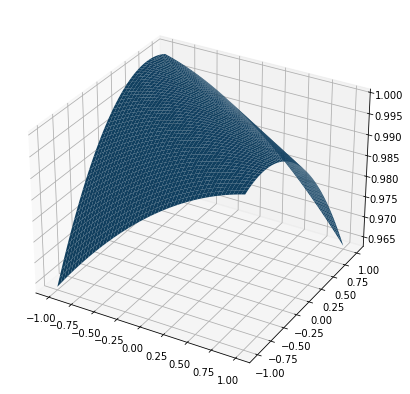

In [436]:
# diagonal motion blur
G, H = add_diagonal_blur(F)
# additive noise
GN = add_gaussian_noise(G)

Display (1) image degraded by motion blur,(2) by motion blur and additive noise

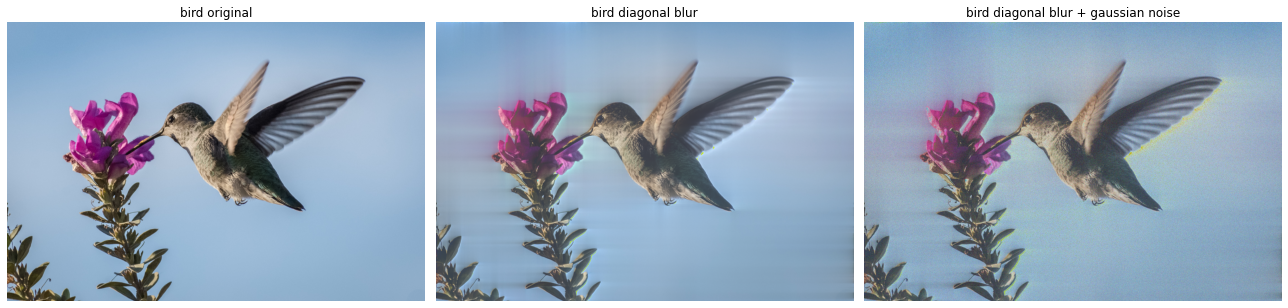

In [437]:
show_images("bird", [F, G, GN], ["original", "diagonal blur", "diagonal blur + gaussian noise"])

## Remove noise
Assume you know H(u,v)

In [438]:
def apply_inverse_filter(g, h):
    # function to apply inverse filtering for motion blur
    r = zeros(g.shape,int)             # out image
    for k in range(0,g.shape[2]):      # loop through colors channels
        c = g[:,:,k].astype(int)       # take color slice
        fc = fft2(c)                   # gather ft and shift to center
        fb = fc/ h                     # inverse operation of the application of this filter
        ifb = ifft2(fb)     # inverse ft
        r[:,:,k] = abs(ifb)            # back to spatial domain

    return r

#### Applying **inverse filter** $ h^{-1} $ on $ G $ .

$ G^{'} = \frac{G(u,v)}{H(u,v)} $

1. $ G $ is the image after **motion blur**
2. $ G $ is the image after **motion blur** and **additive noise**

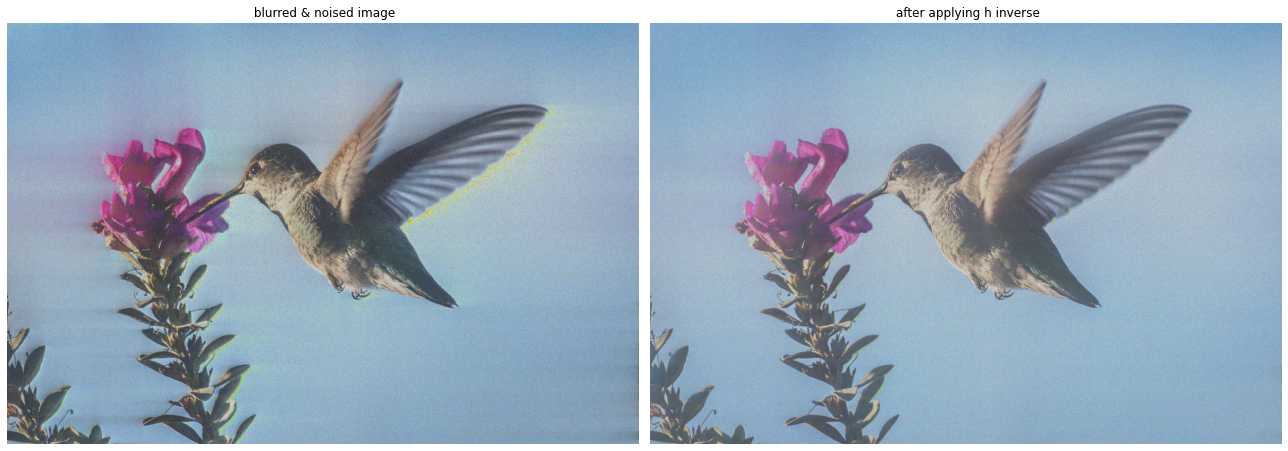

In [439]:
G_ = apply_inverse_filter(G, H)        # 1  motion blurred image
G_N = apply_inverse_filter(GN, H)      # 2  motion blurred and noised image
# showing images
show_images("", [G, G_], ["blurred image", "after applying h inverse"])
show_images("", [GN, G_N], ["blurred & noised image", "after applying h inverse"])

#### Write the equation for the **MMSE** filter $ H_w (u,v) $ when there is only additive noise

In [440]:
def mmse_filter_noise(f, fn):

    r = zeros(f.shape, int)          # out image
    n = fn-f                         # noise by difference between noised image & original image

    for k in range(0,f.shape[2]):
        fs = abs(fftshift(fft2(f[:,:,k]))) ** 2         # original image power spectrum
        ns = abs(fftshift(fft2(n[:,:,k]))) ** 2         # noise power spectrum
        fns = fftshift(fft2(fn[:,:,k]))                 # noised image tf
        # assume h = 1 then
        hw = 1 / (1 + (ns/fs))                          # filter h function
        fr = fns * hw                                   # apply filter in fourier domain
        ifr = ifft2(ifftshift(fr))                      # inverse tf
        r[:,:,k] = abs(ifr)                             # back to spatial domain

    return r

#### Apply this **MMSE** filter $ H_w (u,v) $

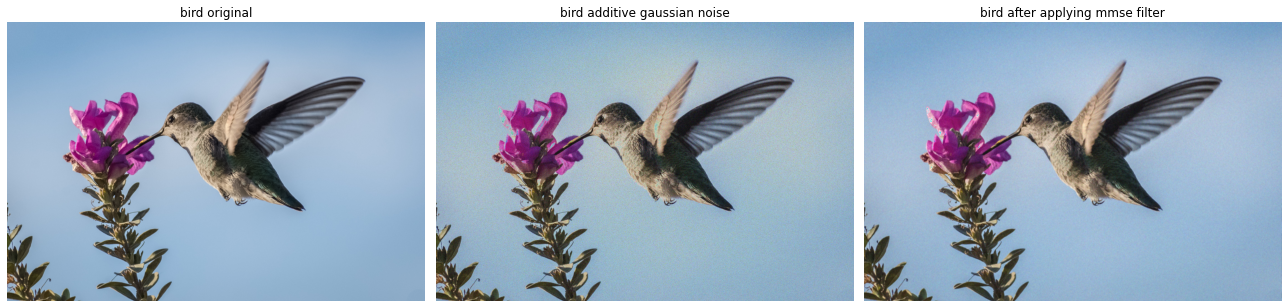

In [441]:
FN = add_gaussian_noise(F)          # only additive noise asked (could have used the restored image but im recycling the function)
FN_ = mmse_filter_noise(F, FN)            # we get back FN_ which is the restored image and N which is the noise
# showing images
show_images("bird", [F,FN, FN_], ["original","additive gaussian noise", "after applying mmse filter"])

#### Write the equation for the **MMSE** filter $ H_w $ when there motion blur and additive noise
Approximate the ratio of the noise power spectrum to original image power spectrum by a constant $ K = \frac{S_{nn}(u,v)}{S_{ff}(u,v)} $

Calculate $ K $ from the average of their true ratio

In [442]:
def mmse_filter_complete(f, h, g):
    r = zeros(f.shape, int)     # out image
    n = g-f                     # noise estimation by difference with original image

    for j in range(0, f.shape[2]):                   # loop through color layers
        fs = abs(fft2(f[:,:, j])) ** 2               # original image power spectrum
        ns = abs(fft2(n[:,:, j])) ** 2               # noise power spectrum
        _k = ns / fs                                 # k - power spectrum ratio
        dh = abs(h) ** 2 + _k                        # wiener filter den
        hw = conj(h) / dh                            # filter h function
        gs = fft2(g[:,:, j])                         # tf of the noised image
        fr = gs * hw                                 # apply filter in frequency domain
        ifr = ifft2(fr)                              # inverse tf
        r[:,:, j] = abs(ifr)                         # back to spatial domain

    return r

#### Apply the resulting **MMSE** filter $ H_w $ to the image
after it has undergone motion blur and additive noise

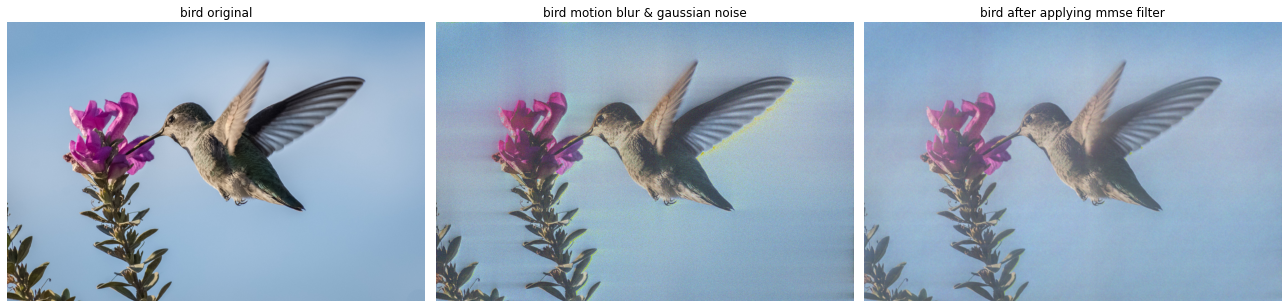

In [443]:
GN_ = mmse_filter_complete(F, H, GN)
show_images("bird", [F,GN, GN_], ["original","motion blur & gaussian noise", "after applying mmse filter"])

